# Проект 2. Разведывательный анализ данных 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

Сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv('stud_math.csv')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [15]:
df.iloc[:, 10:20]

,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery
0,course,mother,2.0,2.0,0.0,yes,no,no,no,yes
1,course,father,1.0,2.0,0.0,no,yes,no,no,no
2,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes
3,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes
4,home,father,1.0,2.0,0.0,no,yes,yes,no,yes
...,...,...,...,...,...,...,...,...,...,...
390,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes
391,course,mother,2.0,1.0,0.0,no,no,no,no,no
392,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no
393,course,mother,3.0,1.0,0.0,no,no,no,NaN,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Описание содержимого колонок:

1. school — аббревиатура школы, в которой учится ученик
2. sex — пол ученика ('F' - женский, 'M' - мужской)
3. age — возраст ученика (от 15 до 22)
4. address — тип адреса ученика ('U' - городской, 'R' - за городом)
5. famsize — размер семьи('LE3' <= 3, 'GT3' >3)
6. Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
7. Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
8. Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
9. Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
10. Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
11. reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
12. guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
13. traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
14. studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
15. failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
16. schoolsup — дополнительная образовательная поддержка (yes или no)
17. famsup — семейная образовательная поддержка (yes или no)
18. paid — дополнительные платные занятия по математике (yes или no)
19. activities — дополнительные внеучебные занятия (yes или no)
20. nursery — посещал детский сад (yes или no)
20. **studytime, granular - ?**
21. higher — хочет получить высшее образование (yes или no)
22. internet — наличие интернета дома (yes или no)
23. romantic — в романтических отношениях (yes или no)
24. famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
25. freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
26. goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
27. health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
28. absences — количество пропущенных занятий
29. score — баллы по госэкзамену по математике

## Первичный анализ данных в столбцах

Номинативные признаки: столбцы 1-2, 4-6, 9-12, 16-20, 22-24

Категориальные признаки: 7-8, 13-15, 21, 25-28

Количественные признаки: 3, 29-30

In [67]:
nominal = list(df.columns[[0,1,3,4,5,8,9,10,11,15,16,17,18,19,21,22,23]])
categorical = list(df.columns[[6,7,12,13,14,20,23,24,25,26,27]])
quantitative = list(df.columns[[2,28,29]])

print('Номинативные признаки: {}\n'.format(nominal))
print('Категориальные признаки: {}\n'.format(categorical))
print('Количественные признаки: {}'.format(quantitative))

Номинативные признаки: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

Категориальные признаки: ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'studytime, granular', 'romantic', 'famrel', 'freetime', 'goout', 'health']

Количественные признаки: ['age', 'absences', 'score']


Первичный анализ включает в себя оценку распределения признака, количества уникальных значений, устранение выбросов. Эти операции можно провести для всех колонок, поэтому будем использовать единую функцию.

In [159]:
# разделила большую функцию (ниже) на подфункции

def get_size(columns):
    """
    
    """
    
    cols = 5
    
    if len(columns) % cols == 0:
        rows = len(columns) // cols
    else:
        rows = (len(columns) + (cols-len(columns)%cols)) // cols
    
    return rows, cols


def resize_columns_list(rows, cols, columns):
    """
    
    """
    
    size = rows * cols
    resized_array = np.hstack((np.array(columns, dtype=str), # fitting in the column names array to the shape of the plot
                         np.full(size-len(columns), fill_value='', dtype=str))).reshape((rows, cols))
    
    return resized_array


def raw_analysis1(columns):
    """
    Primary analysis of columns: number of unique values, values that are found for over 10 times,
    value_counts(), number of non-null values, and bar chart for each one.
    """
    
    rows, cols = get_size(columns)
    fig, axs = plt.subplots(rows, cols, figsize=(18, 3.7*rows)) # plot template
    columns_new = resize_columns_list(rows, cols, columns)
    nunique, over_10, notnull = [], [], []
    
    for index, col in np.ndenumerate(columns_new):
        if col == '':
            axs[index[0], index[1]].get_xaxis().set_visible(False)
            axs[index[0], index[1]].get_yaxis().set_visible(False)
            continue
        else:
            nunique.append(df[col].nunique())
            over_10.append((df[col].value_counts()>10).sum())
            notnull.append(df[col].count())
            
            axs[index[0], index[1]].hist(df[col][df[col].notna()]) # filling in the plot with subplots
            axs[index[0], index[1]].set_title(col)
        
    pivot = pd.DataFrame({'nunique': nunique, 'over_10': over_10, 'notnull': notnull}, index=columns)
    display(pivot)
        
    

,nunique,over_10,notnull
school,2,2,395
sex,2,2,395
age,8,5,395
address,2,2,378
famsize,2,2,368
Pstatus,2,2,350
Medu,5,4,392
Fedu,5,4,370
Mjob,5,5,376
Fjob,5,5,359


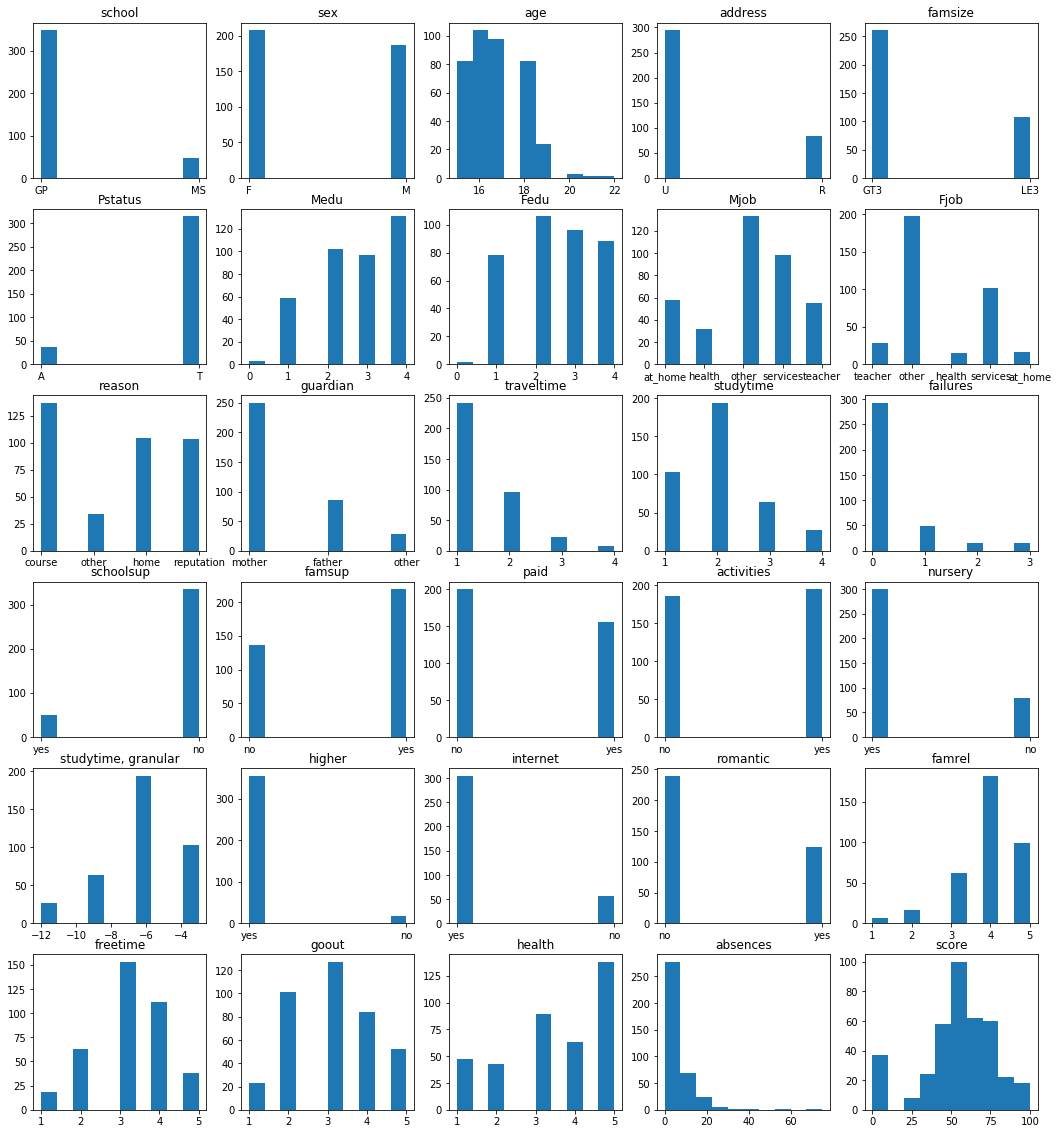

In [158]:
# Анализ колонок, содержащих номинативные признаки

def raw_analysis(columns):
    """
    Primary analysis of columns: number of unique values, values that are found for over 10 times,
    value_counts(), number of non-null values, and bar chart for each one.
    """
    
    rows, cols = 6, 5
    size = rows * cols
    fig, axs = plt.subplots(rows, cols, figsize=(18, 20)) # plot template
    columns_resize = np.hstack((np.array(columns, dtype=str), # fitting in the column names array to the shape of the plot
                         np.full(size-len(columns), fill_value='', dtype=str))).reshape((rows, cols))
    nunique, over_10, notnull = [], [], []
    
    for index, col in np.ndenumerate(columns_resize):
        if col == '':
            axs[index[0], index[1]].get_xaxis().set_visible(False)
            axs[index[0], index[1]].get_yaxis().set_visible(False)
            continue
        else:
#             print('Колонка: {}'.format(col))
#             print('Уникальных значений: {}; значений, встретившихся более 10 раз: {}'.format(
#                 df[col].nunique(), (df[col].value_counts()>10).sum())
#                  )
            nunique.append(df[col].nunique())
            over_10.append((df[col].value_counts()>10).sum())
            notnull.append(df[col].count())
            
#             display(pd.DataFrame(df[col].value_counts()))
#             display(df.loc[:, [col]].info())
            
            axs[index[0], index[1]].hist(df[col][df[col].notna()]) # filling in the plot with subplots
            axs[index[0], index[1]].set_title(col)
        
    pivot = pd.DataFrame({'nunique': nunique, 'over_10': over_10, 'notnull': notnull}, index=columns)
    display(pivot)
        
        
# cols1 = list(df.columns[:2]) + list(df.columns[3:28])
raw_analysis(df.columns)

Выводы из вышеизложенного:

1. Колонки содержат небольшое число пропусков.
2. Пропуски заполнены корректно, содержат np.nan values.
3. В целом колонки заполнены правильно, содержат только предполагаемые значения. Выбросы (ошибки заполнения) содержатся только в **Fedu** (>4), **famrel** (<0), скорее всего, **absences** (>100) и, возможно, **score** (ближе к 0). Эти колонки рассмотрим отдельно.

In [5]:
# Fedu может содержать только целые значения от 0 до 4, остальные заменяем np.nan
df['Fedu'] = df['Fedu'].apply(lambda x: x if x in range(0, 5) else np.nan)
df['Fedu'].value_counts()

2.0    106
3.0     96
4.0     88
1.0     78
0.0      2
Name: Fedu, dtype: int64

In [6]:
# famrel может содержать только целые значения от 1 до 5, остальные заменяем np.nan
df['famrel'] = df['famrel'].apply(lambda x: x if x in range(1, 6) else np.nan)
df['famrel'].value_counts()

4.0    182
5.0     99
3.0     62
2.0     17
1.0      7
Name: famrel, dtype: int64

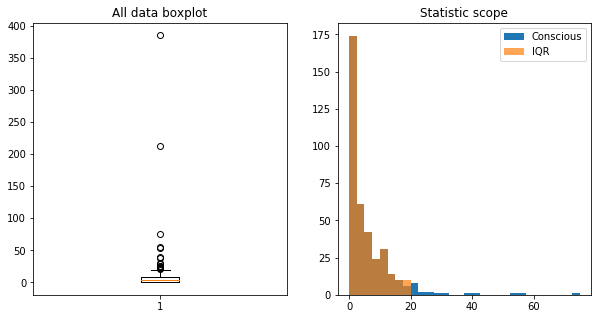

In [7]:
# absences нужно обрабатывать стат. методами

def stat_for_col(column): 
    median = df[column].median()
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    iqr = perc75 - perc25
    return median, perc25, perc75, iqr
    

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].boxplot(df['absences'][df['absences'].notna()]) # визуализируем выбросы
axs[0].set_title('All data boxplot')

median, perc25, perc75, iqr = stat_for_col('absences') # находим численные занчения стат параметров

axs[1].hist(df['absences'][df['absences'] < 100], label='Conscious', bins=30) # отбрасываем только 2 выброса, которые >100
axs[1].hist(df['absences'][df['absences'].between(perc25-1.5*iqr, perc75+1.5*iqr)], label='IQR', bins=8, alpha=0.7)
axs[1].set_title('Statistic scope')
axs[1].legend()

In [8]:
# количество выбросов между максимумом стат. разброса данных и 100
display(pd.DataFrame(df['absences'][df['absences'].between(perc75+1.5*iqr, 100)].sort_values()))

,absences
311,20.0
118,20.0
304,20.0
237,20.0
260,21.0
313,22.0
277,22.0
216,22.0
320,23.0
198,24.0


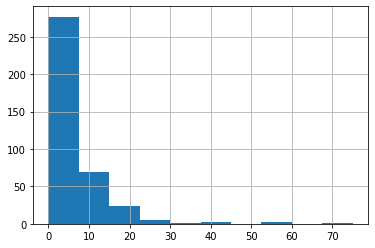

In [13]:
# в данном интервале содержится довольно много потенциально реальных значений, 
# поэтому отбрасываем только 2 явных выброса >100
df['absences'] = df['absences'].apply(lambda x: x if x <= 100 else np.nan)

df['absences'].hist()

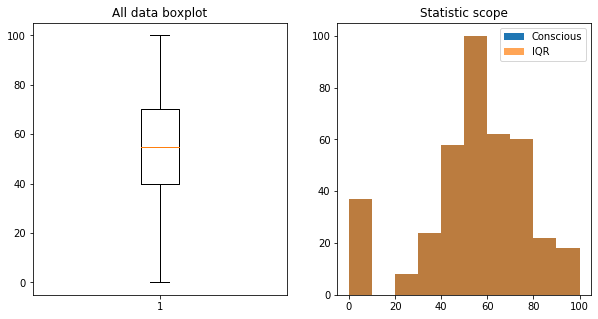

In [38]:
# проверим, есть ли в score выбросы, стат. методами

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].boxplot(df['score'][df['score'].notna()]) # визуализируем выбросы
axs[0].set_title('All data boxplot')

median, perc25, perc75, iqr = stat_for_col('score') # находим численные занчения стат параметров

axs[1].hist(df['score'][df['score'].notna()], label='Conscious', bins=10)
axs[1].hist(df['score'][df['score'].between(perc25-1.5*iqr, perc75+1.5*iqr)], label='IQR', bins=10, alpha=0.7)
axs[1].set_title('Statistic scope')
axs[1].legend()

In [39]:
# как видим, в колонке нет выбросов, корректировать ее не нужно

## Корреляционный анализ

**1. Колонки, содержащие количественные переменные**

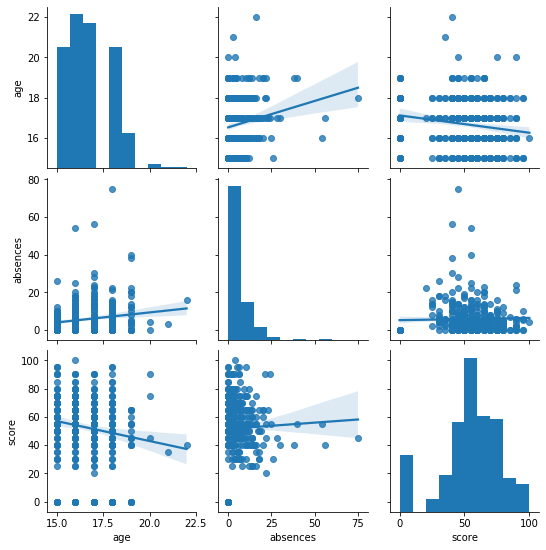

In [29]:
sns.pairplot(df.loc[:, df.columns.isin(quantitative)], kind='reg')

In [33]:
df.loc[:, df.columns.isin(quantitative)].corr()

,age,absences,score
age,1.000000,0.166773,-0.155726
absences,0.166773,1.000000,0.031698
score,-0.155726,0.031698,1.000000


**Выводы:**

1. Колонки слабо коррелируют между собой, все параметры могут оказывать влияние на успеваемость по математике.
2. Рассмотренные колонки необходимо оставить.

**2. Колонки, содержащие численные переменные**

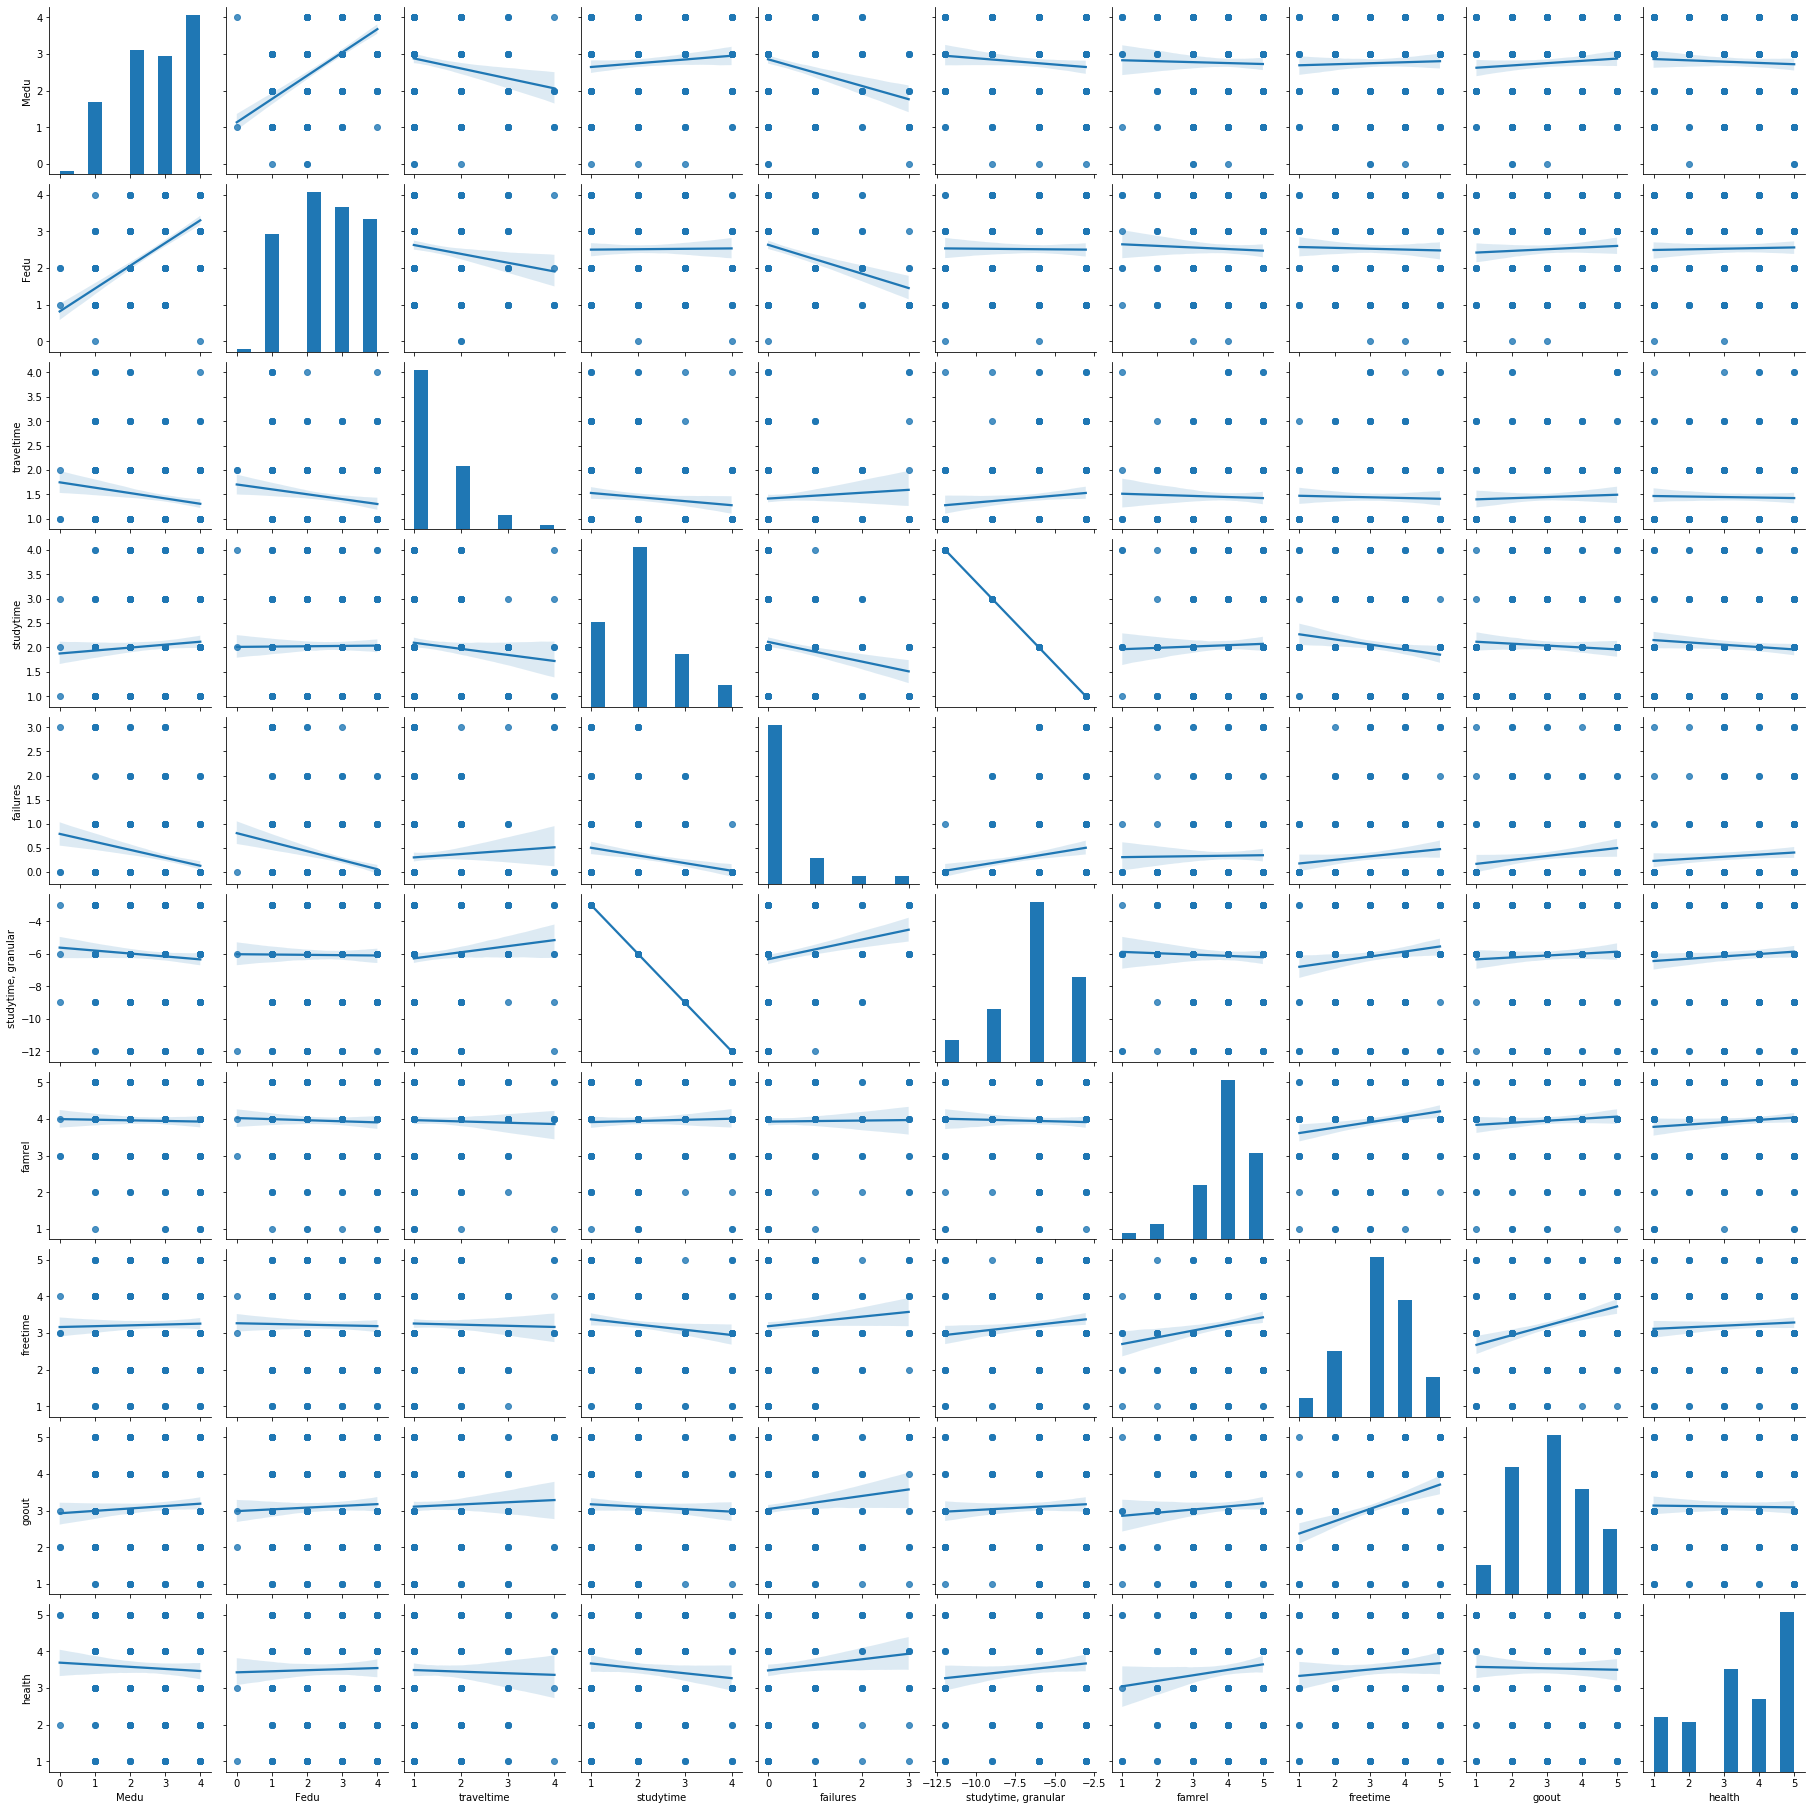

In [30]:
sns.pairplot(df.loc[:, df.columns.isin(categorical)], kind='reg')

In [42]:
corr1 = df.loc[:, df.columns.isin(categorical)].corr()
corr1

,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health
Medu,1.000000,0.629956,-0.173515,0.078589,-0.245463,-0.078589,-0.020896,0.025335,0.064164,-0.045051
Fedu,0.629956,1.000000,-0.155459,0.008603,-0.271936,-0.008603,-0.035788,-0.021415,0.046581,0.022588
traveltime,-0.173515,-0.155459,1.000000,-0.102206,0.064699,0.102206,-0.028220,-0.021937,0.037636,-0.021531
studytime,0.078589,0.008603,-0.102206,1.000000,-0.178992,-1.000000,0.028918,-0.121969,-0.051280,-0.080016
failures,-0.245463,-0.271936,0.064699,-0.178992,1.000000,0.178992,0.011942,0.098382,0.120914,0.081284
"studytime, granular",-0.078589,-0.008603,0.102206,-1.000000,0.178992,1.000000,-0.028918,0.121969,0.051280,0.080016
famrel,-0.020896,-0.035788,-0.028220,0.028918,0.011942,-0.028918,1.000000,0.164324,0.069241,0.097910
freetime,0.025335,-0.021415,-0.021937,-0.121969,0.098382,0.121969,0.164324,1.000000,0.296437,0.061575
goout,0.064164,0.046581,0.037636,-0.051280,0.120914,0.051280,0.069241,0.296437,1.000000,-0.015608
health,-0.045051,0.022588,-0.021531,-0.080016,0.081284,0.080016,0.097910,0.061575,-0.015608,1.000000


In [55]:
corr1[abs(corr1) > 0.5]

,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health
Medu,1.000000,0.629956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fedu,0.629956,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
traveltime,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
studytime,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN
failures,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
"studytime, granular",NaN,NaN,NaN,-1.0,NaN,1.0,NaN,NaN,NaN,NaN
famrel,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
freetime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
goout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
health,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


**Выводы:**

1. Колонки <i>studytime</i> и <i>studytime, granular</i> полностью коррелируют, последнюю удаляем.
2. 

In [63]:
# целесообразно ли переводить да/нет в 1/0?

df1 = pd.DataFrame(df.iloc[:, [15,16,17,18,19,21,22,23]])

for col in df1.columns:
    df1[col] = df1[col].apply(lambda x: 1 if 'yes' in str(x).lower() else 0 if 'no' in str(x).lower() else np.nan)
    
df1

,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,1.0,0.0,0.0,0.0,1.0,1.0,NaN,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,NaN,0.0,1.0,1.0,1.0,NaN
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
390,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
391,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
392,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0
393,0.0,0.0,0.0,NaN,0.0,1.0,1.0,0.0


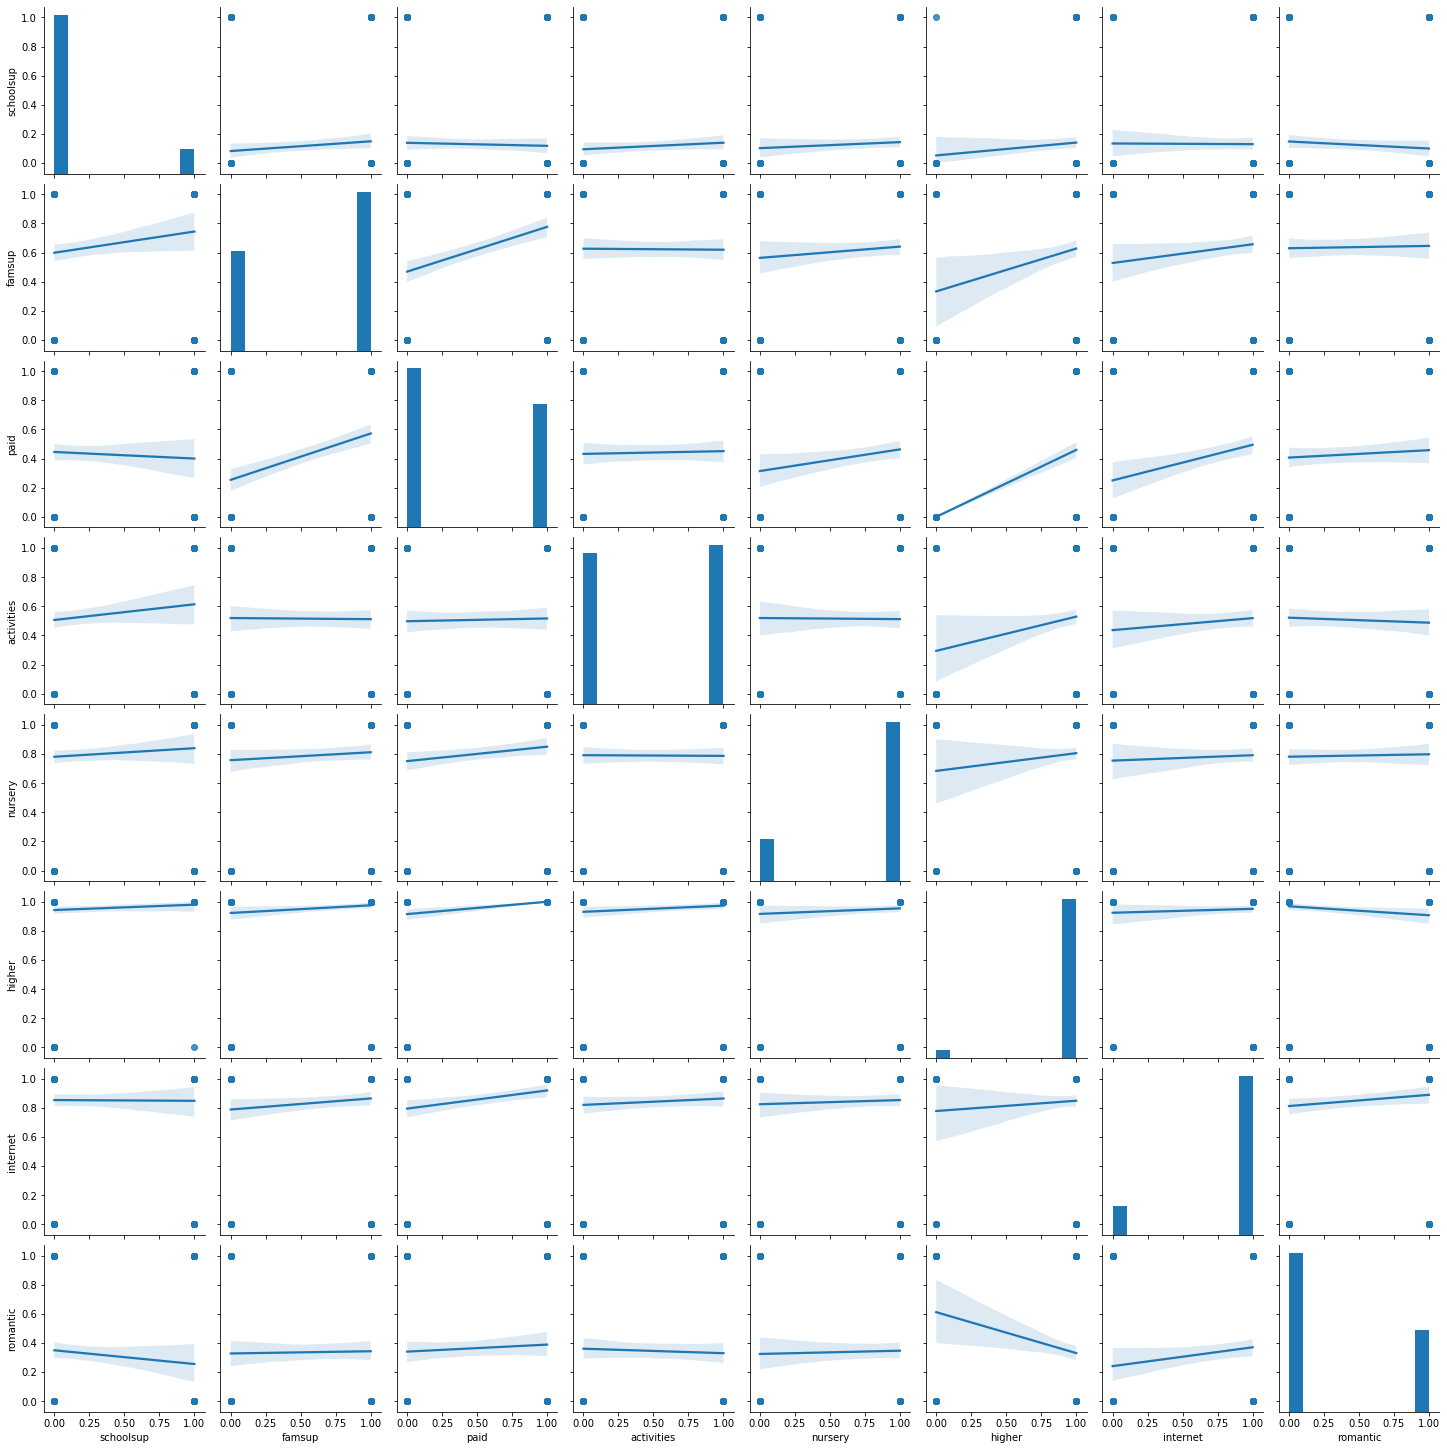

In [64]:
sns.pairplot(df1, kind='reg')

In [66]:
df1.corr()

,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
schoolsup,1.000000,0.098607,-0.030622,0.069506,0.049241,0.056949,-0.004859,-0.067455
famsup,0.098607,1.000000,0.312699,-0.007412,0.064869,0.124554,0.098795,0.015542
paid,-0.030622,0.312699,1.000000,0.019044,0.121350,0.197203,0.174581,0.049475
activities,0.069506,-0.007412,0.019044,1.000000,-0.006010,0.099606,0.060126,-0.032455
nursery,0.049241,0.064869,0.121350,-0.006010,1.000000,0.068030,0.032580,0.019314
higher,0.056949,0.124554,0.197203,0.099606,0.068030,1.000000,0.043522,-0.131382
internet,-0.004859,0.098795,0.174581,0.060126,0.032580,0.043522,1.000000,0.099781
romantic,-0.067455,0.015542,0.049475,-0.032455,0.019314,-0.131382,0.099781,1.000000


## Анализ номинативных переменных

In [180]:
def get_boxplots(columns):
    """
    
    """
    
    rows, cols = get_size(columns)
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(18, 3.7*rows)) # plot template
    fig.text(0.093, 0.5, 'math score', va='center', rotation='vertical') # set common y axis
    columns_new = resize_columns_list(rows, cols, columns)
    
    for index, col in np.ndenumerate(columns_new):
        if col == '':
            axs[index[0], index[1]].get_xaxis().set_visible(False) # hiding axes
            axs[index[0], index[1]].get_yaxis().set_visible(False)
            continue
        else:
            sns.boxplot(x=col, y='score', data=df, ax=axs[index[0], index[1]])
            plt.xticks(rotation=45)
            axs[index[0], index[1]].set_title('Boxplot for ' + col)
            axs[index[0], index[1]].set_xlabel('') # is there another method to hide axes labels?
            axs[index[0], index[1]].set_ylabel('')
#             axs[index[0], index[1]].tick_params(labelrotation=45) # rotate x ticks on 45 deg
    
    plt.show()

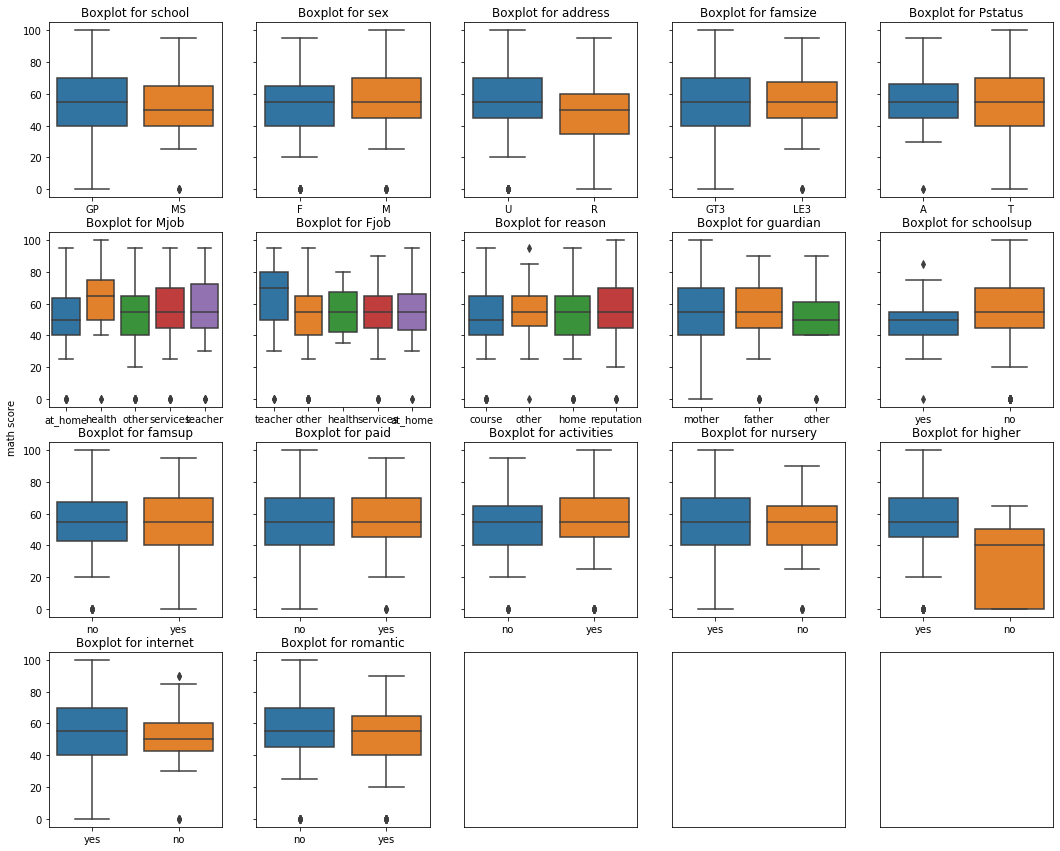

In [181]:
get_boxplots(nominal)

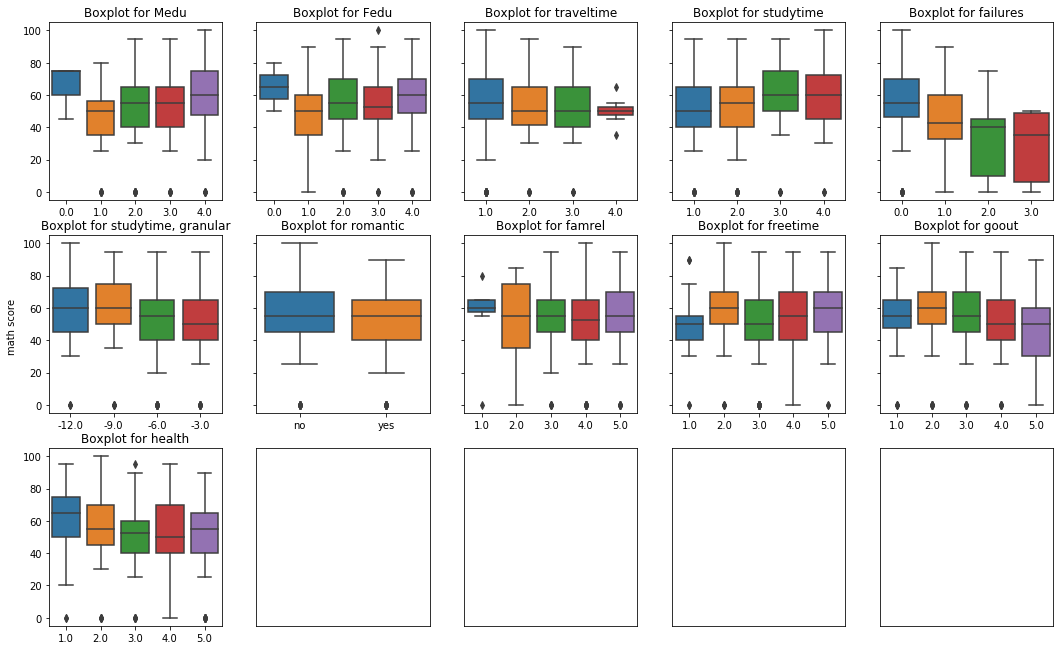

In [182]:
get_boxplots(categorical)

In [204]:
def get_stat_dif(column):
    combs = list(combinations(df[column].value_counts().index, 2))
    
    for comb in combs:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.10/len(combs): # Учли поправку Бонферрони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [205]:
for column in nominal:
    get_stat_dif(column)

Найдены статистически значимые различия для колонки Mjob


In [207]:
for column in categorical:
    get_stat_dif(column)
print('finished')

finished


In [79]:
df.loc[:, df.columns.isin(categorical)].head()

,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",romantic,famrel,freetime,goout,health
0,4.0,4.0,2.0,2.0,0.0,-6.0,no,4.0,3.0,4.0,3.0
1,1.0,1.0,1.0,2.0,0.0,-6.0,no,5.0,3.0,3.0,3.0
2,1.0,1.0,1.0,2.0,3.0,-6.0,NaN,4.0,3.0,2.0,3.0
3,4.0,2.0,1.0,3.0,0.0,-9.0,yes,3.0,2.0,2.0,5.0
4,3.0,3.0,1.0,2.0,0.0,-6.0,no,4.0,3.0,2.0,5.0


In [78]:
df.loc[:, df.columns.isin(nominal)].head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,NaN,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,NaN,no
1,GP,F,U,GT3,NaN,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,NaN,no,yes,yes,yes,NaN
3,GP,F,U,GT3,T,health,NaN,home,mother,no,yes,yes,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,other,other,home,father,no,yes,yes,no,yes,yes,no,no


In [77]:
df.loc[:, df.columns.isin(quantitative)].head()

,age,absences,score
0,18,6.0,30.0
1,17,4.0,30.0
2,15,10.0,50.0
3,15,2.0,75.0
4,16,4.0,50.0
